In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.metrics import cdist_dtw, dtw_path
from sklearn.metrics import silhouette_score
import pickle


/samoa/data/smrserraoseabr/anaconda3/envs/ge3/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [15]:


def perform_elbow_analysis(file_path, max_clusters=10, sep=';'):
    data = pd.read_csv(file_path, index_col=0, sep=sep)
    data_reset = data.reset_index()
    long_df = data_reset.melt(id_vars=['Id'], var_name='Time', value_name='Value')
    long_df.sort_values(by=['Id', 'Time'], inplace=True)

    grouped = long_df.groupby('Id')['Value'].apply(list)
    max_length = grouped.apply(len).max()
    uniform_series = grouped.apply(lambda x: x + [np.nan] * (max_length - len(x)))

    ts_data = to_time_series_dataset(list(uniform_series))
    scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
    ts_scaled = scaler.fit_transform(ts_data)

    inertia = []
    for k in range(1, max_clusters + 1):
        model = TimeSeriesKMeans(n_clusters=k, metric="euclidean", verbose=False)
        model.fit(ts_scaled)
        inertia.append(model.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters + 1), inertia, marker='o')
    plt.title('Elbow Method for Determining Optimal Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()


def fit_model_and_visualize_clusters(file_path, n_clusters, sep=';'):
    # Load and preprocess data
    data = pd.read_csv(file_path, index_col=0, sep=sep)
    data_reset = data.reset_index()
    long_df = data_reset.melt(id_vars=['Id'], var_name='Time', value_name='Value')
    long_df.sort_values(by=['Id', 'Time'], inplace=True)

    grouped = long_df.groupby('Id')['Value'].apply(list)
    max_length = grouped.apply(len).max()
    uniform_series = grouped.apply(lambda x: x + [np.nan] * (max_length - len(x)))

    ts_data = to_time_series_dataset(list(uniform_series))
    scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
    ts_scaled = scaler.fit_transform(ts_data)

    # Fit the model
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", verbose=True)
    y_pred = model.fit_predict(ts_scaled)

    # Visualize clusters
    plt.figure(figsize=(12, 8))
    for yi in range(n_clusters):
        plt.subplot(n_clusters, 1, yi + 1)
        for xx in ts_scaled[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=0.2)
        plt.plot(model.cluster_centers_[yi].ravel(), "r-")
        plt.title(f"Cluster {yi + 1}")
        plt.xlim([0, max_length])
    plt.tight_layout()
    plt.show()

    return model, scaler



def predict_cluster(consumption_file, model, scaler):
    # Reshape the timeseries_sample
    data = pd.read_csv(consumption_file, index_col=0, sep=';')
    data = data.sample(1)
    data_reset = data.reset_index()
    long_df = data_reset.melt(id_vars=['Id'], var_name='Time', value_name='Value')
    long_df.sort_values(by=['Id', 'Time'], inplace=True)
    grouped = long_df.groupby('Id')['Value'].apply(list)
    max_length = grouped.apply(len).max()
    uniform_series = grouped.apply(lambda x: x + [np.nan] * (max_length - len(x)))
    ts_data = to_time_series_dataset(list(uniform_series))
    ts_scaled = scaler.fit_transform(ts_data)
    cluster = model.predict(ts_scaled)
    return cluster





 



Elbow analysis for 1 year of consumption data


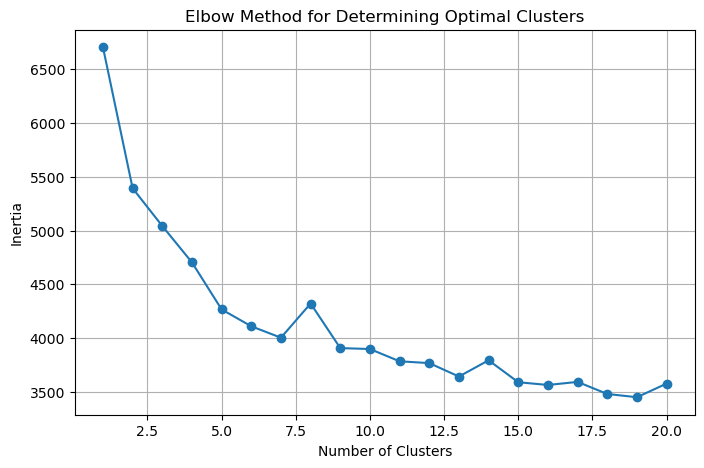

Elbow analysis for 3 years of consumption data


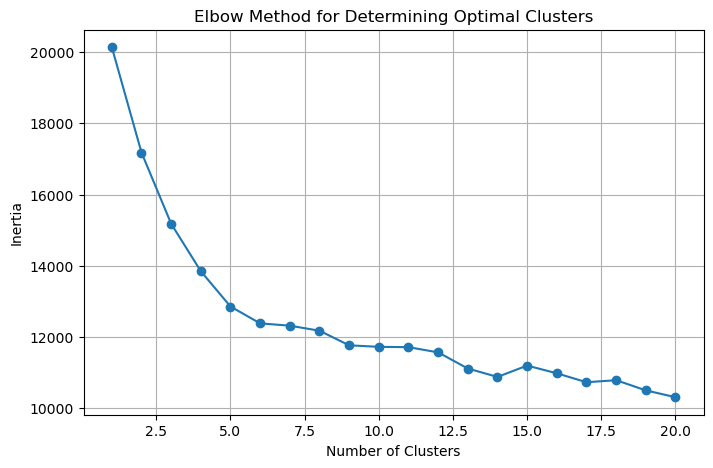

Elbow analysis for 1 year of production data


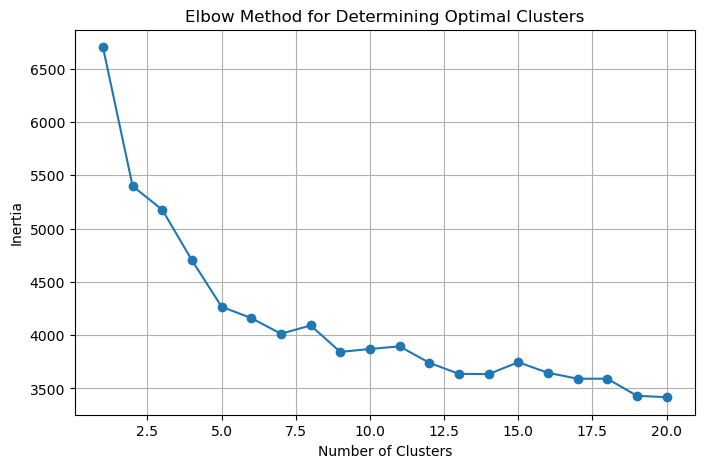

Elbow analysis for 3 years of production data


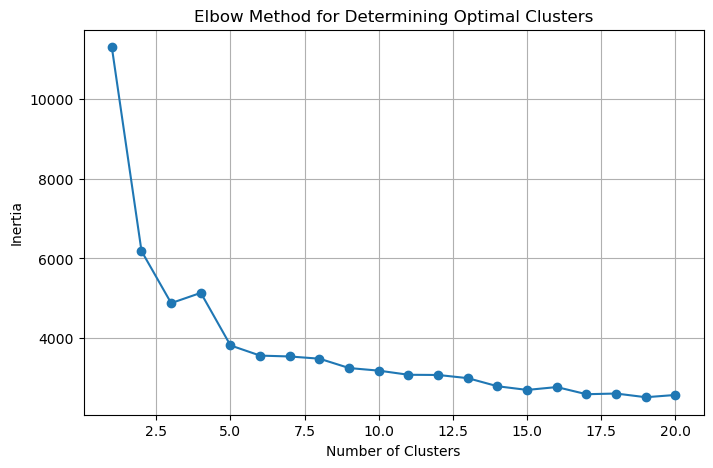

In [12]:
# Determine optimal clusters
consumption1y = "/samoa/data/smrserraoseabr/hackadelft/hackathon/dataset/consumption-1y-processed.csv"
print("Elbow analysis for 1 year of consumption data")
perform_elbow_analysis(consumption1y, max_clusters=20)

consumption3y = "/samoa/data/smrserraoseabr/hackadelft/hackathon/dataset/consumption-3y-processed.csv"
print("Elbow analysis for 3 years of consumption data")
perform_elbow_analysis(consumption3y, max_clusters=20)

production1y = "/samoa/data/smrserraoseabr/hackadelft/hackathon/dataset/production-1y-processed.csv"
print("Elbow analysis for 1 year of production data")
perform_elbow_analysis(production1y, max_clusters=20)

production3y = "/samoa/data/smrserraoseabr/hackadelft/hackathon/dataset/production-3y-processed.csv"
print("Elbow analysis for 3 years of production data")
perform_elbow_analysis(production3y, max_clusters=20)




4902.119 --> 3997.027 --> 3960.711 --> 3955.081 --> 3954.117 --> 3952.968 --> 3952.000 --> 3950.264 --> 3950.264 --> 


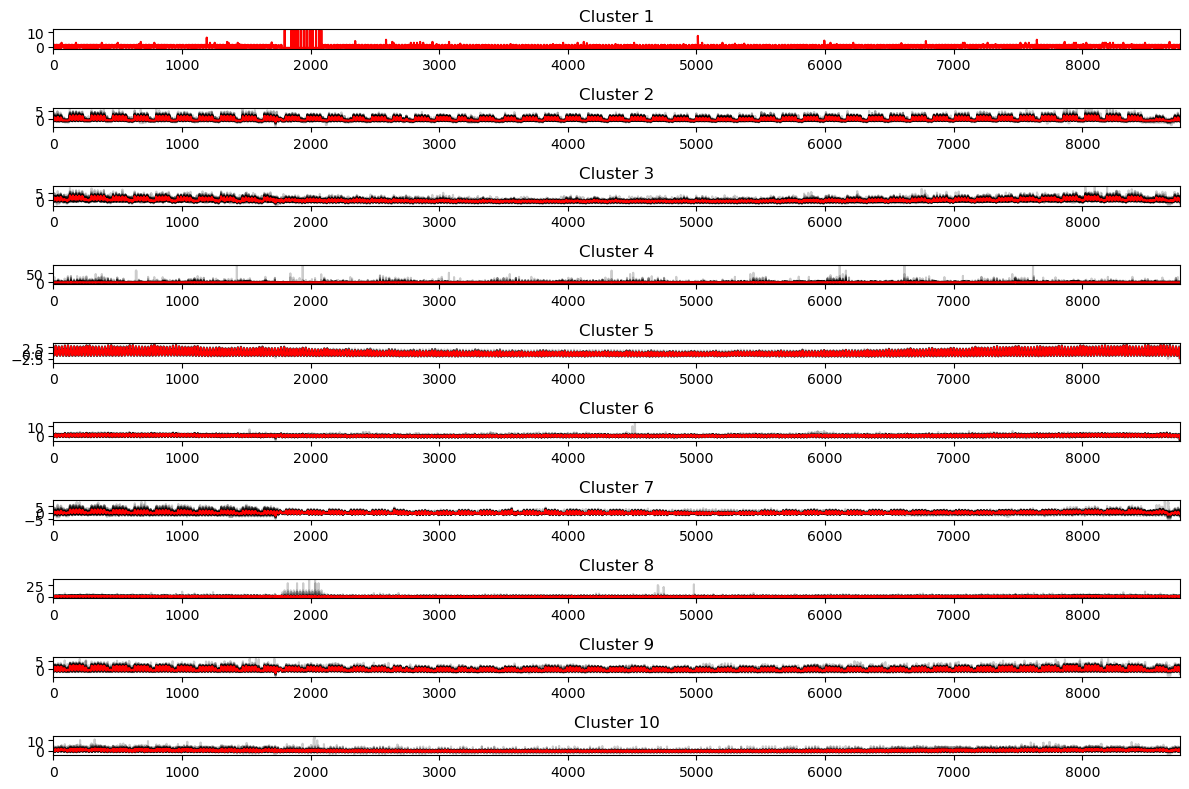

15710.272 --> 11984.901 --> 11652.973 --> 11563.207 --> 11527.364 --> 11518.908 --> 11518.908 --> 


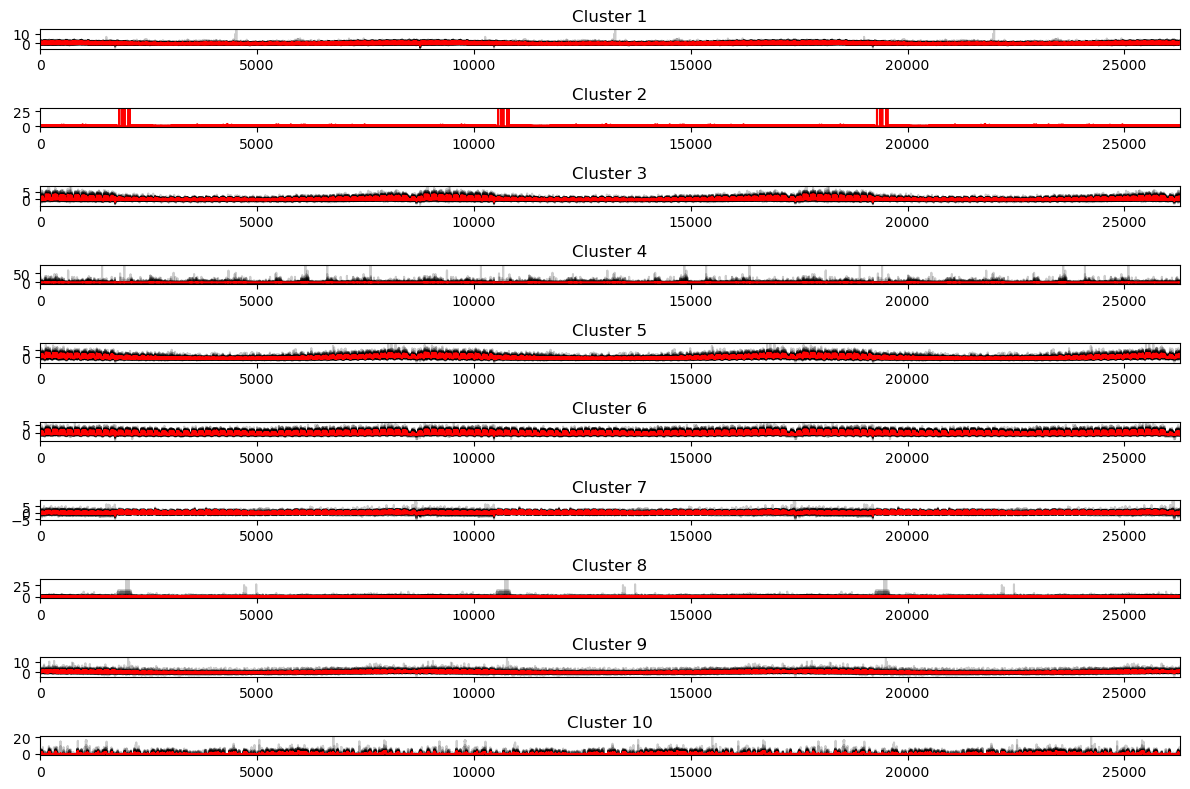

5145.877 --> 4040.851 --> 3992.926 --> 3972.339 --> 3959.922 --> 3949.987 --> 3942.837 --> 3937.279 --> 3934.486 --> 3933.309 --> 3933.007 --> 3933.007 --> 


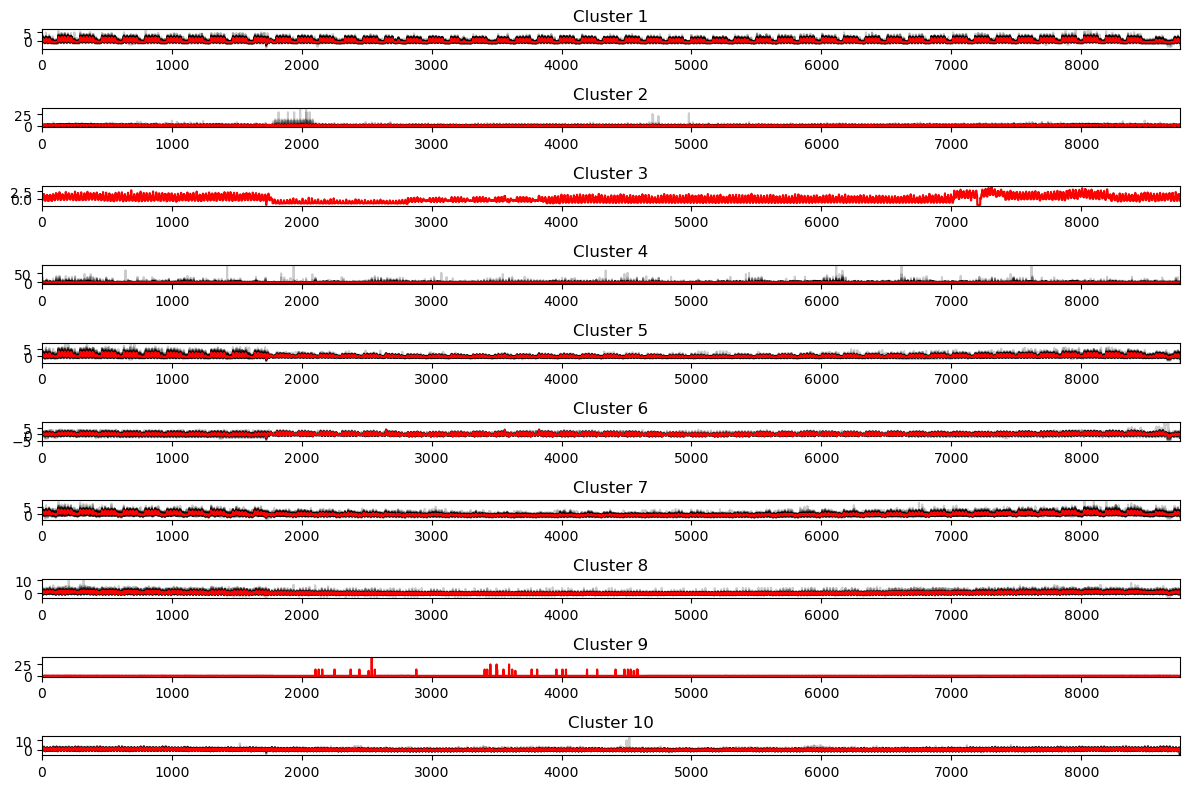

4124.831 --> 3268.340 --> 3227.797 --> 3201.728 --> 3191.659 --> 3188.752 --> 3186.332 --> 3182.275 --> 3164.629 --> 3148.379 --> 3143.824 --> 3140.953 --> 3139.813 --> 3139.636 --> 3138.995 --> 3138.995 --> 


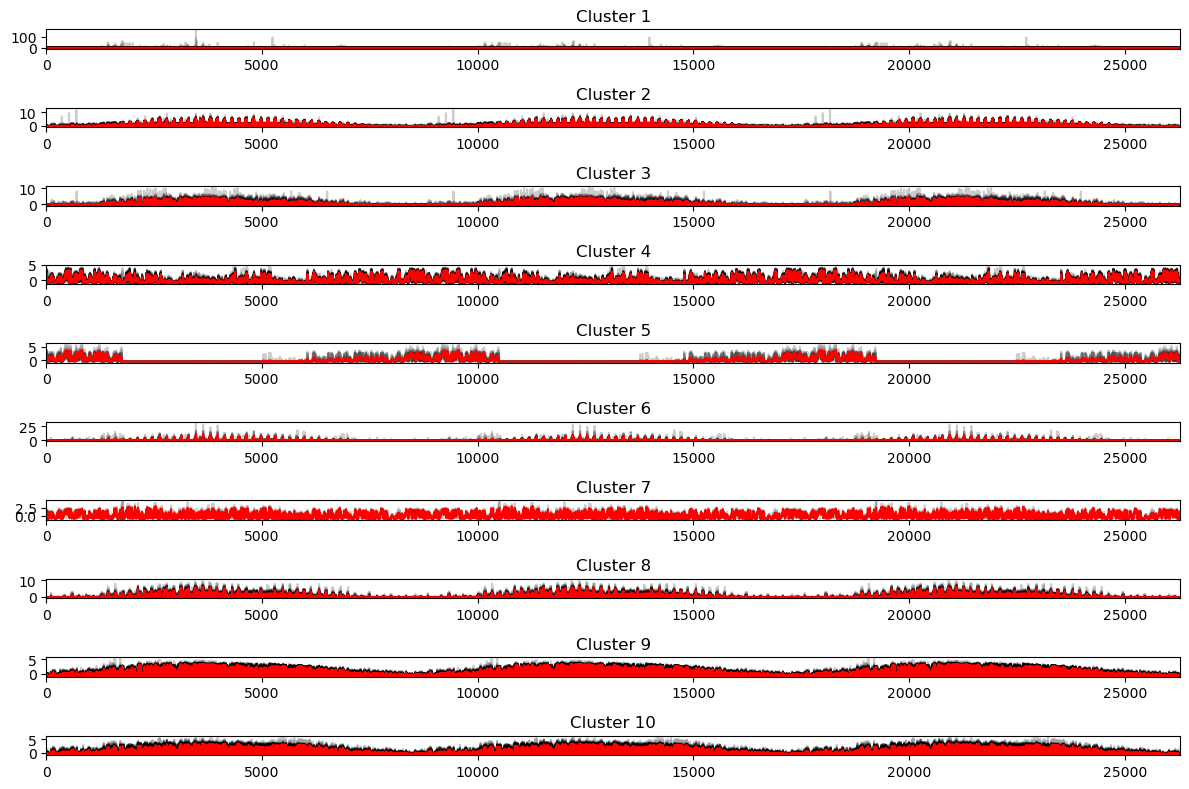

In [16]:
#Fit all the models using 10 clusters
model_consumption1y, scaler_consumption1y = fit_model_and_visualize_clusters(consumption1y, 10)
model_consumption3y, scaler_consumption3y = fit_model_and_visualize_clusters(consumption3y, 10)
model_production1y, scaler_production1y = fit_model_and_visualize_clusters(production1y, 10)
model_production3y, scaler_production3y = fit_model_and_visualize_clusters(production3y, 10)



In [58]:
def fit_model_and_identify_representatives(file_path, n_clusters, sep=';'):
    # Load and preprocess data
    data = pd.read_csv(file_path, index_col=0, sep=sep)
    data_reset = data.reset_index()
    long_df = data_reset.melt(id_vars=['Id'], var_name='Time', value_name='Value')
    long_df.sort_values(by=['Id', 'Time'], inplace=True)

    grouped = long_df.groupby('Id')['Value'].apply(list)
    max_length = grouped.apply(len).max()
    uniform_series = grouped.apply(lambda x: x + [np.nan] * (max_length - len(x)))

    ts_data = to_time_series_dataset(list(uniform_series))
    scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
    ts_scaled = scaler.fit_transform(ts_data)

    # Fit the model
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", verbose=True)
    y_pred = model.fit_predict(ts_scaled)

    # Find representative time series and their Ids
    representatives = []
    representative_ids = []
    for k in range(n_clusters):
        cluster_center = model.cluster_centers_[k]
        # Calculate distances within the cluster
        distances = cdist_dtw(ts_scaled[y_pred == k], cluster_center.reshape(1, -1, 1))
        # Get the index of the minimum distance
        representative_idx = np.argmin(distances)
        representatives.append(ts_data[y_pred == k][representative_idx])
        representative_ids.append(data_reset['Id'][y_pred == k].iloc[representative_idx])

    # Visualize clusters
    plt.figure(figsize=(12, 8))
    for yi in range(n_clusters):
        plt.subplot(n_clusters, 1, yi + 1)
        for xx in ts_scaled[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=0.2)
        plt.plot(model.cluster_centers_[yi].ravel(), "r-")
        plt.title(f"Cluster {yi + 1}")
        plt.xlim([0, max_length])
    plt.tight_layout()
    plt.show()

    return model, scaler, representatives, representative_ids


5312.722 --> 4041.961 --> 3954.486 --> 3936.627 --> 3926.369 --> 3922.148 --> 3920.193 --> 3919.248 --> 3919.248 --> 


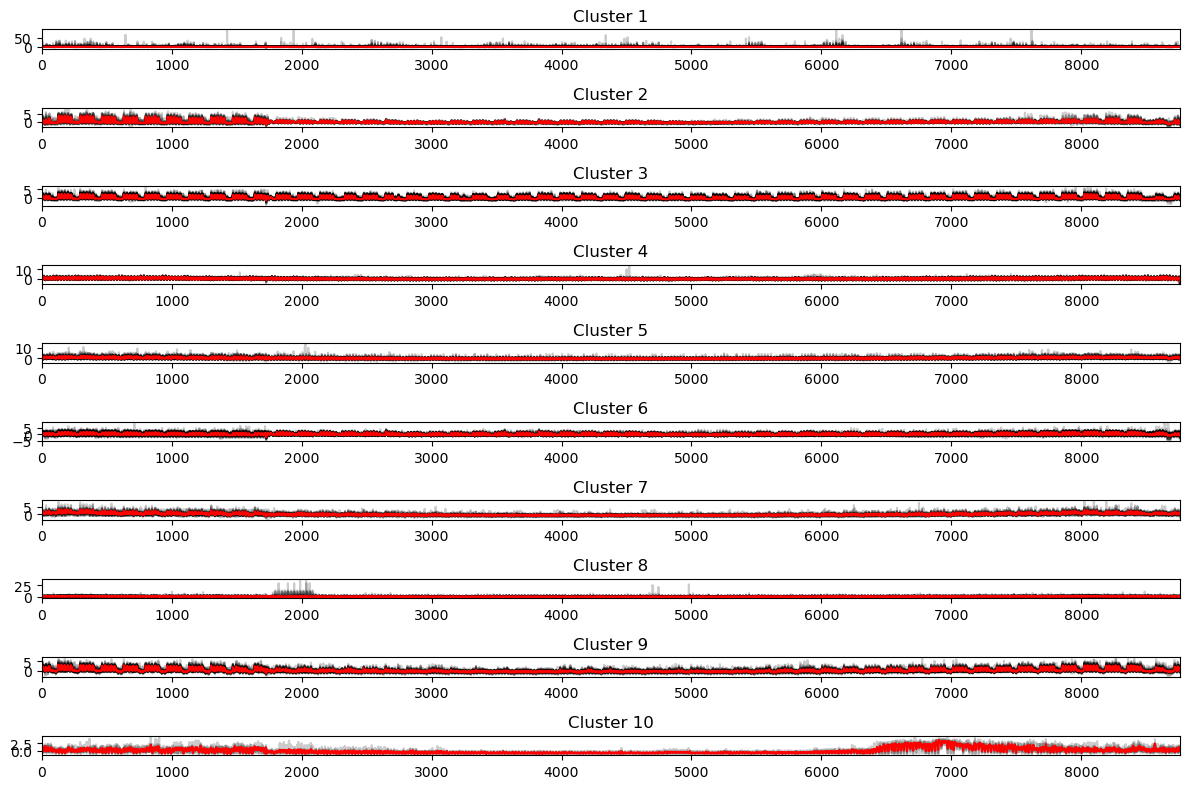

15421.350 --> 12380.906 --> 12146.794 --> 12074.581 --> 12045.110 --> 12031.427 --> 12027.040 --> 12027.040 --> 


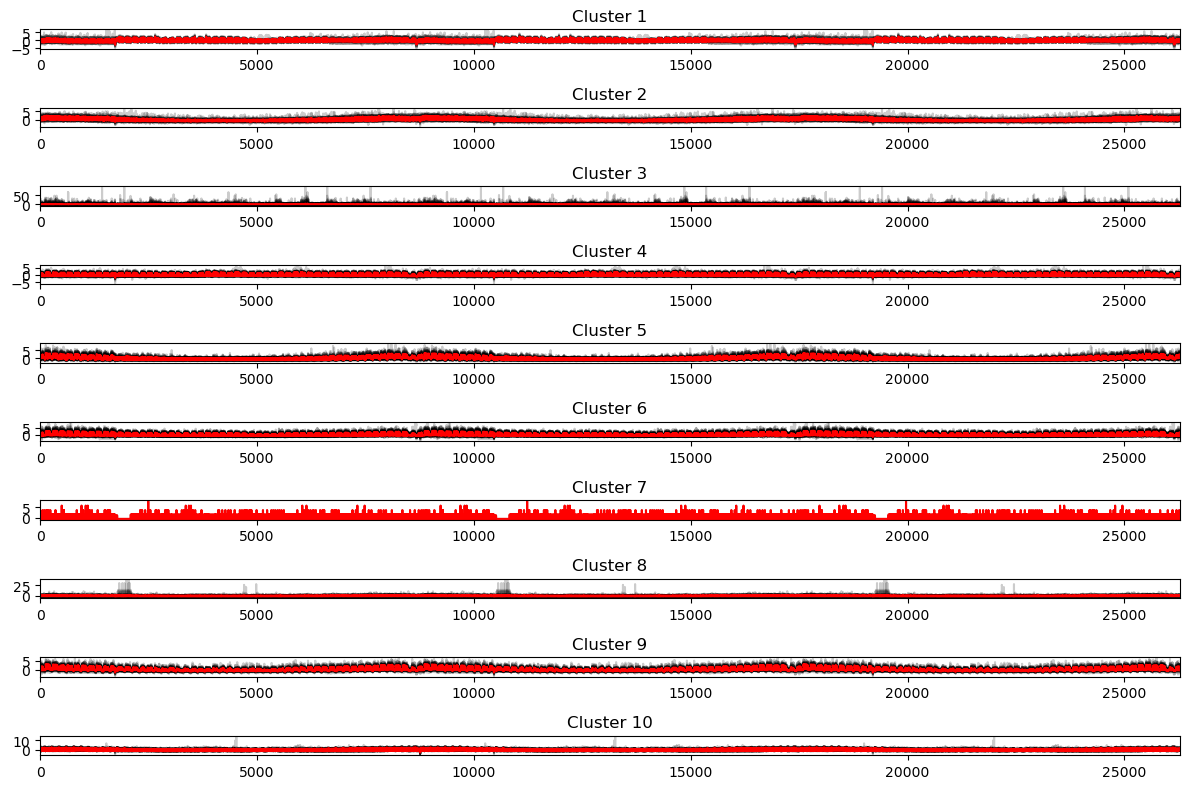

5073.645 --> 4169.829 --> 4057.354 --> 3940.554 --> 3848.199 --> 3822.463 --> 3816.120 --> 3815.558 --> 3814.789 --> 3814.093 --> 3812.885 --> 3812.885 --> 


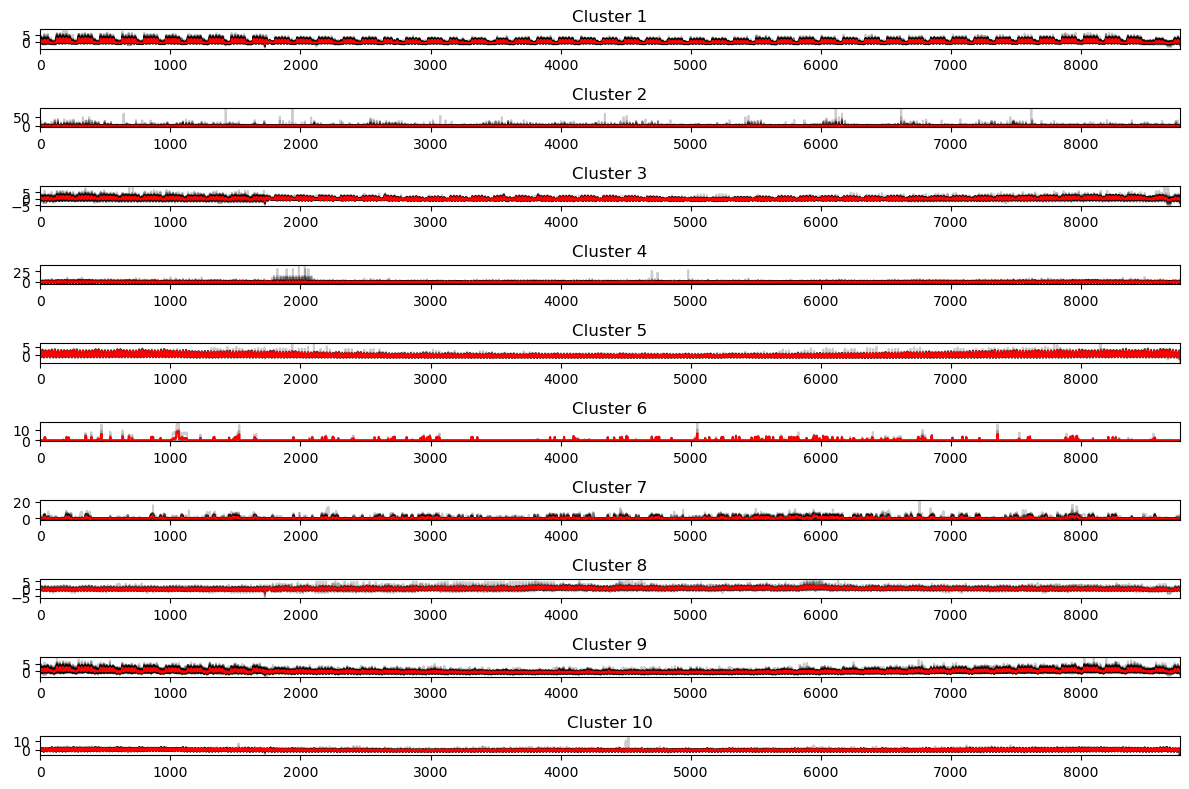

4098.921 --> 3251.856 --> 3210.764 --> 3202.162 --> 3194.916 --> 3181.367 --> 3175.681 --> 3175.323 --> 3175.323 --> 


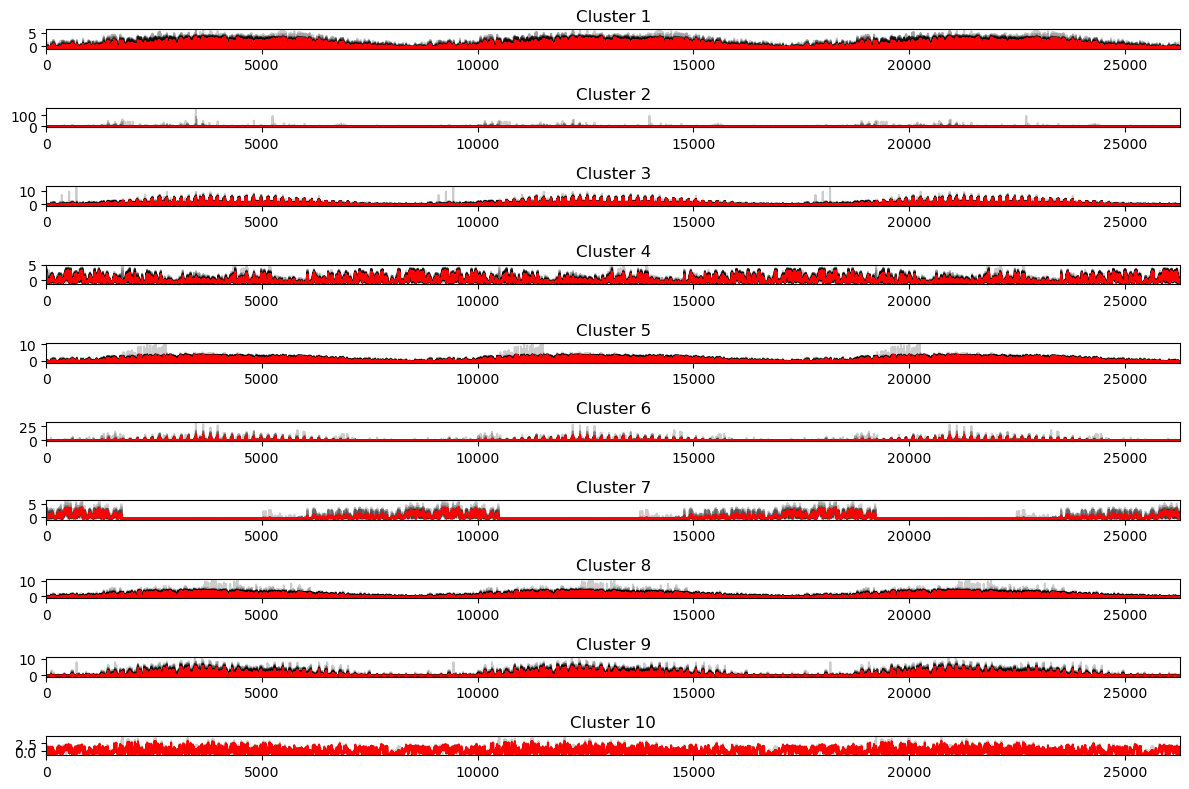

Representative time series for Cluster 1: [0. 0. 0. ... 0. 0. 0.]
Representative time series for Cluster 2: [149.95314 149.33524 141.94617 ... 156.33025 149.10301 140.68015]
Representative time series for Cluster 3: [273.25003 270.64526 270.0651  ... 275.43732 275.66733 196.65337]
Representative time series for Cluster 4: [0.738418   0.71070075 0.65449876 ... 0.6899291  0.74065095 0.18714266]
Representative time series for Cluster 5: [6.702587  6.324262  6.1158285 ... 8.6183    7.0869975 1.7047437]
Representative time series for Cluster 6: [303.18594 294.03043 279.97116 ... 295.59982 312.37134 121.01382]
Representative time series for Cluster 7: [175.76999 170.31596 173.42265 ... 181.8649  183.78777 167.95341]
Representative time series for Cluster 8: [3.12 3.12 3.12 ... 2.88 3.36 2.88]
Representative time series for Cluster 9: [170.188   166.45099 166.292   ... 213.841   208.22    187.49799]
Representative time series for Cluster 10: [57.   43.9  34.   ... 38.55 38.9  40.65]
Represent

In [59]:
n_clusters = 10
model_consumption1y, scaler_consumption1y, representatives_consumption1y, representative_ids_consumption1y = fit_model_and_identify_representatives(consumption1y, n_clusters)
model_consumption3y, scaler_consumption3y, representatives_consumption3y, representative_ids_consumption3y = fit_model_and_identify_representatives(consumption3y, n_clusters)
model_production1y, scaler_production1y, representatives_production1y, representative_ids_production1y = fit_model_and_identify_representatives(production1y, n_clusters)
model_production3y, scaler_production3y, representatives_production3y, representative_ids_production3y = fit_model_and_identify_representatives(production3y, n_clusters)

for idx, ts in enumerate(representatives_consumption1y):
    print(f"Representative time series for Cluster {idx + 1}: {ts.ravel()}")    
    
for idx, ts in enumerate(representatives_consumption3y):
    print(f"Representative time series for Cluster {idx + 1}: {ts.ravel()}")

for idx, ts in enumerate(representatives_production1y):
    print(f"Representative time series for Cluster {idx + 1}: {ts.ravel()}")

for idx, ts in enumerate(representatives_production3y):
    print(f"Representative time series for Cluster {idx + 1}: {ts.ravel()}")



In [60]:
# Save models and scalers to pickle
with open('model_consumption1y.pkl', 'wb') as f:
    pickle.dump(model_consumption1y, f)
with open('scaler_consumption1y.pkl', 'wb') as f:
    pickle.dump(scaler_consumption1y, f)

with open('model_consumption3y.pkl', 'wb') as f:
    pickle.dump(model_consumption3y, f)
with open('scaler_consumption3y.pkl', 'wb') as f:
    pickle.dump(scaler_consumption3y, f)

with open('model_production1y.pkl', 'wb') as f:
    pickle.dump(model_production1y, f)
with open('scaler_production1y.pkl', 'wb') as f:
    pickle.dump(scaler_production1y, f)

with open('model_production3y.pkl', 'wb') as f:
    pickle.dump(model_production3y, f)
with open('scaler_production3y.pkl', 'wb') as f:
    pickle.dump(scaler_production3y, f)

# Save representatives and representative_ids to pandas DataFrame
representatives_df = pd.DataFrame({
    'representatives_consumption1y': representatives_consumption1y,
    'representative_ids_consumption1y': representative_ids_consumption1y,
    'representatives_consumption3y': representatives_consumption3y,
    'representative_ids_consumption3y': representative_ids_consumption3y,
    'representatives_production1y': representatives_production1y,
    'representative_ids_production1y': representative_ids_production1y,
    'representatives_production3y': representatives_production3y,
    'representative_ids_production3y': representative_ids_production3y
})

representatives_df.to_pickle('representatives_df.pkl')


In [61]:
representatives_df

,representatives_consumption1y,representative_ids_consumption1y,representatives_consumption3y,representative_ids_consumption3y,representatives_production1y,representative_ids_production1y,representatives_production3y,representative_ids_production3y
0,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",12,"[[3.676], [3.91], [3.999], [3.767], [3.414], [...",386,"[[273.25003], [270.64526], [270.0651], [266.93...",8,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",145
1,"[[149.95314], [149.33524], [141.94617], [148.2...",382,"[[175.76999], [170.31596], [173.42265], [164.1...",67,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",12,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",3
2,"[[273.25003], [270.64526], [270.0651], [266.93...",8,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",12,"[[11.38797], [11.37906], [11.564685], [11.5349...",473,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",425
3,"[[0.738418], [0.71070075], [0.65449876], [0.62...",361,"[[602.96954], [602.06757], [600.9375], [603.53...",51,"[[2.398], [2.398], [2.399], [2.398], [2.198], ...",297,"[[5335.3467], [6297.418], [6664.9126], [6575.2...",60
4,"[[6.702587], [6.324262], [6.1158285], [5.97661...",394,"[[72.014], [62.391003], [68.784004], [59.495],...",369,"[[5.2406826], [4.7619405], [4.227912], [3.8417...",404,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",179
5,"[[303.18594], [294.03043], [279.97116], [287.3...",387,"[[621.0337], [606.999], [588.5496], [589.8231]...",6,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",111,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",465
6,"[[175.76999], [170.31596], [173.42265], [164.1...",67,"[[0.0], [0.05], [0.0], [0.05], [0.0], [0.05], ...",251,"[[15.908], [15.562], [15.213], [8.017], [1.565...",60,"[[5524.188], [5380.092], [5486.202], [5490.972...",421
7,"[[3.12], [3.12], [3.12], [2.88], [3.36], [2.88...",104,"[[3.12], [3.12], [3.12], [2.88], [3.36], [2.88...",104,"[[151.119], [147.059], [140.04], [146.3], [162...",206,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",262
8,"[[170.188], [166.45099], [166.292], [163.42899...",306,"[[170.188], [166.45099], [166.292], [163.42899...",306,"[[175.76999], [170.31596], [173.42265], [164.1...",67,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",6
9,"[[57.0], [43.9], [34.0], [42.65], [57.1], [43....",243,"[[0.738418], [0.71070075], [0.65449876], [0.62...",361,"[[0.738418], [0.71070075], [0.65449876], [0.62...",361,"[[275.094], [279.828], [275.389], [266.811], [...",284


## Predicting a cluster based on a timeseries and on a model and scaler previously runned 

In [7]:
# Load models and scalers from pickle
with open('models/model_consumption1y.pkl', 'rb') as f:
    model_consumption1y = pickle.load(f)
with open('models/scaler_consumption1y.pkl', 'rb') as f:
    scaler_consumption1y = pickle.load(f)

with open('models/model_consumption3y.pkl', 'rb') as f:
    model_consumption3y = pickle.load(f)
with open('models/scaler_consumption3y.pkl', 'rb') as f:
    scaler_consumption3y = pickle.load(f)

with open('models/model_production1y.pkl', 'rb') as f:
    model_production1y = pickle.load(f)
with open('models/scaler_production1y.pkl', 'rb') as f:
    scaler_production1y = pickle.load(f)

with open('models/model_production3y.pkl', 'rb') as f:
    model_production3y = pickle.load(f)
with open('models/scaler_production3y.pkl', 'rb') as f:
    scaler_production3y = pickle.load(f)

# Load representatives and representative_ids from pandas DataFrame
representatives_df = pd.read_pickle('models/representatives_df.pkl')

# Test the loaded models and scalers
test_data = representatives_df.iloc[0]['representatives_consumption1y'].reshape(1, -1, 1)

# Scale the test data
scaled_test_data_consumption1y = scaler_consumption1y.transform(test_data)
#scaled_test_data_consumption3y = scaler_consumption3y.transform(test_data)
#scaled_test_data_production1y = scaler_production1y.transform(test_data)
#scaled_test_data_production3y = scaler_production3y.transform(test_data)

# Make predictions
prediction_consumption1y = model_consumption1y.predict(scaled_test_data_consumption1y)
#prediction_consumption3y = model_consumption3y.predict(scaled_test_data_consumption3y)
#prediction_production1y = model_production1y.predict(scaled_test_data_production1y)
#prediction_production3y = model_production3y.predict(scaled_test_data_production3y)

# Print predictions
print("Prediction for consumption 1 year:", prediction_consumption1y)
#print("Prediction for consumption 3 years:", prediction_consumption3y)
#print("Prediction for production 1 year:", prediction_production1y)
#print("Prediction for production 3 years:", prediction_production3y)


Prediction for consumption 1 year: [0]
